In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cycler
import matplotlib as mpl
from sklearn.decomposition import PCA
from neurodsp import sim

## SSA

from http://karthur.org/2017/learning-for-time-series-ssa-vs-pca.html

How to apply an optimal window and step size automatically?

## Multi exponent test, SSA version

In [4]:
def pca(data, num):
    if type(data) != np.ndarray:
        data = np.array(data)
    
    pca = PCA(n_components = num)
    pca.fit(data.T)
    components, spec  = pca.components_, pca.explained_variance_ratio_
    return components, spec

def delay_embed(data, m, step = 1, norm = True):
    """m is window length"""
    data = np.array(data)
    nt = data.shape[0] #length of original vector
    n = int((nt-m+1)/step) #number of lags
    traj_mat = np.empty((0,m)) #initialize delay embedded trajectory matrix
    for i in range(n):
        window_i = data[i*step:i*step + m]
        traj_mat = np.append(traj_mat, [window_i], axis=0 )
    
    if norm:
        traj_mat = (1/(nt**0.5)) * traj_mat #normalize by 1/sqrt(n)
    return traj_mat

def SSA(data, m, step, norm = True, return_traj = False):
    """Performs SSA on time series with window size m and inter-window step size"""
    if type(data) != np.ndarray:
        data = np.array(data)
    nt = data.shape[0] #length of original vector
    n = int((nt-m+1)/step) #number of lags
    
    traj_mat = delay_embed(data, m, step, norm)
    components, e_spectrum = pca(traj_mat, n)
#      =PCA(n_components = n)
#     pca.fit(traj_mat.T)
#     components = pca.components_
#     e_spectrum = pca.explained_variance_ratio_
    
    if not return_traj:
        return components, e_spectrum
    else:
        return components, e_spectrum, traj_mat
    


In [24]:
exponents = np.arange(-4,0.2,0.2)

signals2 = {} #1d now since only one fBm per exponent
ssa_results = {}
for exp in exponents:
    exp = round(exp, 1) #why is this even necessary
    signal = sim.sim_powerlaw(n_seconds=300, fs=500, f_range = None, exponent=exp)
        
    ssa_results[str(exp)] = SSA(signal, m = 5000, step = 1500)

In [ ]:
ssa_results.shape[0]

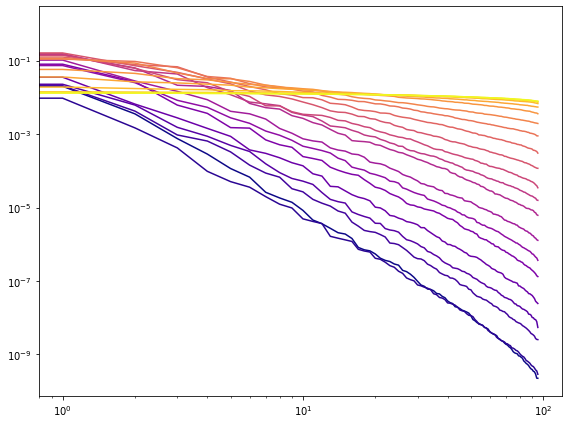

In [26]:
n_ = exponents.shape[0]
color = plt.cm.plasma(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
plt.figure(figsize=(8,6))

for i, exp in enumerate(exponents):
    exp = round(exp, 1)
    plt.loglog(ssa_results[str(exp)][1]); 

    #plt.title(r'$\alpha$ = '+str(exp))

#plt.xlim([1,300])
plt.tight_layout()    
plt.show()

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
plt.plot(signals['0.0'][1])
plt.subplot(1,2,2)
components, spec = SSA(signals[0], m = 5000, step = 1000)
colors = plt.cm.viridis(np.linspace(0,1,5))
for i in range(5):
    plt.plot(components[i], color =colors[i], label='PC ' + str(i+1))
    plt.legend()
    
plt.figure()
plt.loglog(spec)